# RNN
This notebook based on [this tf tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#inspect_and_cleanup)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('data_ML.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,open,high,low,close,volume,bb_bbh,bb_bbl,bb_bbm,ATR,ROCI_10,ROCI_20,ROCI_40,ROCI_60,ROCI_120,close_change
date,,,,,,,,,,,,,,,
2011-03-29,1.4086,1.4148,1.4047,1.4113,64044,1.411300,1.411300,1.411300,0.0,0.0,0.0,0.0,0.0,0.0,0
2011-03-30,1.4113,1.4146,1.4052,1.4126,70281,1.413250,1.410650,1.411950,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-03-31,1.4127,1.4232,1.4116,1.4174,73492,1.419013,1.408520,1.413767,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-04-01,1.4173,1.4245,1.4061,1.4234,70943,1.425675,1.406675,1.416175,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-04-04,1.4231,1.4268,1.4192,1.4218,61094,1.426915,1.407685,1.417300,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
open,2048.0,1.224839,0.110876,1.038700,1.125185,1.222320,1.321508,1.482900
high,2048.0,1.229779,0.111035,1.041720,1.130540,1.227165,1.326790,1.493800
low,2048.0,1.219965,0.110473,1.033950,1.120327,1.216680,1.316502,1.480300
close,2048.0,1.224812,0.110868,1.038710,1.125290,1.221240,1.321623,1.482900
volume,2048.0,69968.092285,31029.993580,1.000000,50027.500000,66702.500000,85864.750000,251895.000000
bb_bbh,2048.0,1.247025,0.112603,1.059360,1.144809,1.242740,1.344603,1.500058
bb_bbl,2048.0,1.205254,0.110062,1.028955,1.106788,1.202059,1.301213,1.422685
bb_bbm,2048.0,1.226140,0.110884,1.047205,1.123544,1.225930,1.321040,1.457885
ATR,2048.0,0.009823,0.002995,0.000000,0.007888,0.009194,0.011114,0.018876
ROCI_10,2048.0,-0.099127,1.635318,-6.168910,-1.105194,-0.069678,0.938442,5.800075


## Preparing the data

In [5]:
df.drop('close_change', axis=1, inplace=True)
target_column = 'close'
df.head()

,open,high,low,close,volume,bb_bbh,bb_bbl,bb_bbm,ATR,ROCI_10,ROCI_20,ROCI_40,ROCI_60,ROCI_120
date,,,,,,,,,,,,,,
2011-03-29,1.4086,1.4148,1.4047,1.4113,64044,1.411300,1.411300,1.411300,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-30,1.4113,1.4146,1.4052,1.4126,70281,1.413250,1.410650,1.411950,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-31,1.4127,1.4232,1.4116,1.4174,73492,1.419013,1.408520,1.413767,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-01,1.4173,1.4245,1.4061,1.4234,70943,1.425675,1.406675,1.416175,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-04,1.4231,1.4268,1.4192,1.4218,61094,1.426915,1.407685,1.417300,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'open': 0,
 'high': 1,
 'low': 2,
 'close': 3,
 'volume': 4,
 'bb_bbh': 5,
 'bb_bbl': 6,
 'bb_bbm': 7,
 'ATR': 8,
 'ROCI_10': 9,
 'ROCI_20': 10,
 'ROCI_40': 11,
 'ROCI_60': 12,
 'ROCI_120': 13}

In [7]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

normalizing

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

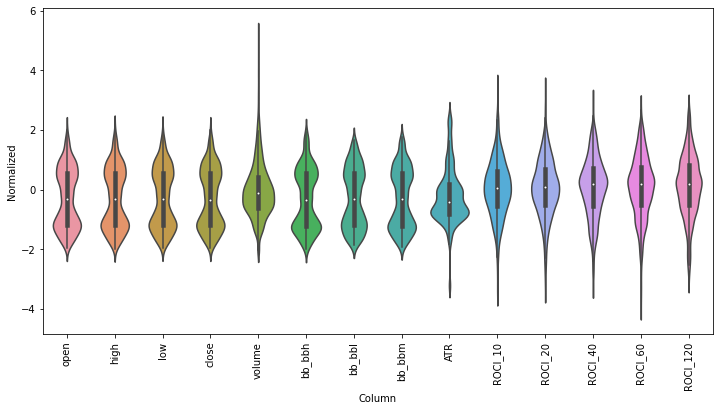

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Windows generation

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df,val_df=val_df, test_df=test_df,
                label_columns=None):
        
        #Storing raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [11]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=24,
                     label_columns=[target_column])
w1

Total window size: 46
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [45]
Label column name(s): ['close']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[target_column])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [13]:
w2.total_window_size

7

Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

In [14]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [15]:
WindowGenerator.split_window = split_window

In [16]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)


### plot

In [17]:
def plot(self, model=None, plot_col='close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [18]:
w2.example = example_inputs, example_labels

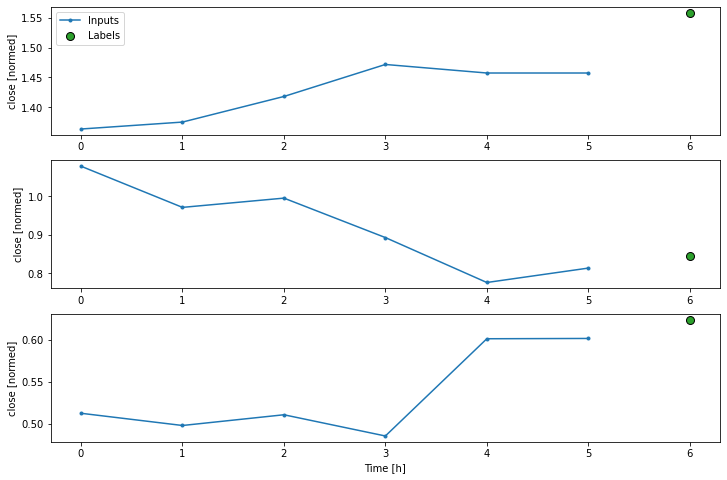

In [19]:
w2.plot()

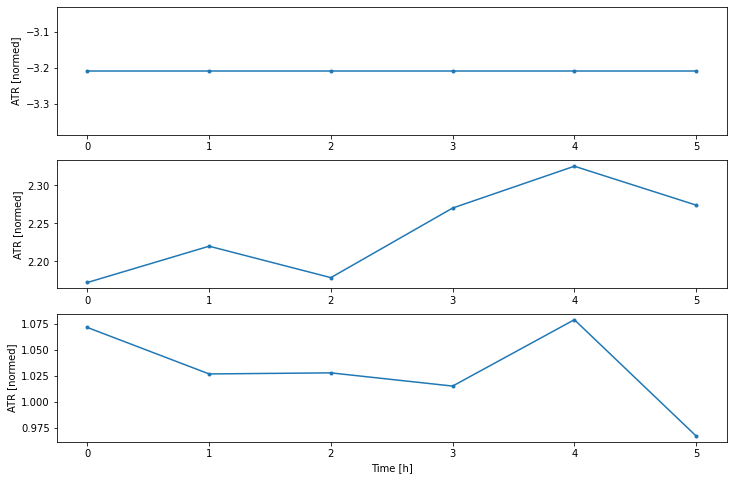

In [20]:
w2.plot(plot_col='ATR')


In [21]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
w2.train.element_spec

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [24]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 6, 14)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models

In [25]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target_column])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [26]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


In [27]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [28]:
'''
baseline = Baseline(label_index=column_indices[target_column])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
'''

"\nbaseline = Baseline(label_index=column_indices[target_column])\n\nbaseline.compile(loss=tf.losses.MeanSquaredError(),\n                 metrics=[tf.metrics.MeanAbsoluteError()])\n\nval_performance = {}\nperformance = {}\nval_performance['Baseline'] = baseline.evaluate(single_step_window.val)\nperformance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)\n"

In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target_column])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [30]:
baseline = Baseline(label_index=column_indices[target_column])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 0s 760us/step - loss: 0.0023 - mean_absolute_error: 0.0376


In [31]:
#wide_window.example

In [32]:
print('Input shape:', wide_window.example[0].shape)
#baseline(wide_window.example[0]).shape
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


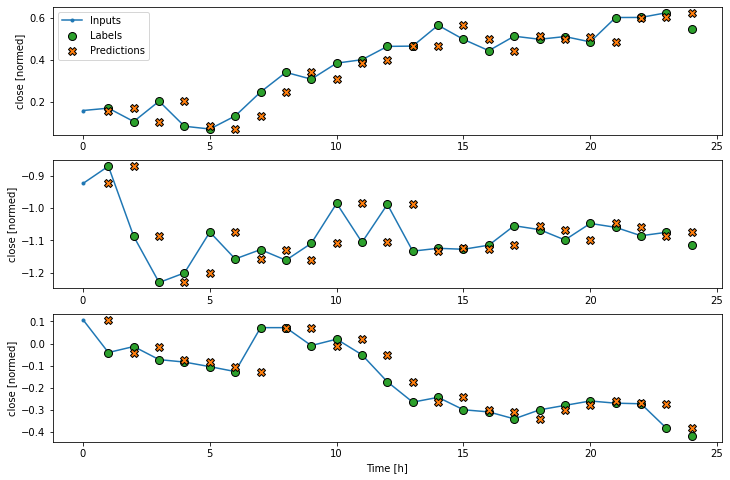

In [33]:
wide_window.plot(baseline)

## Linear model

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [35]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [37]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
45/45 [==============================] - 0s 4ms/step - loss: 2.0685 - mean_absolute_error: 1.1984 - val_loss: 1.3879 - val_mean_absolute_error: 0.9282
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 1.2228 - mean_absolute_error: 0.9129 - val_loss: 0.8338 - val_mean_absolute_error: 0.7335
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.7036 - mean_absolute_error: 0.6812 - val_loss: 0.5042 - val_mean_absolute_error: 0.5792
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.4202 - mean_absolute_error: 0.5147 - val_loss: 0.3261 - val_mean_absolute_error: 0.4703
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2792 - mean_absolute_error: 0.4119 - val_loss: 0.2340 - val_mean_absolute_error: 0.4011
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2134 - mean_absolute_error: 0.3560 - val_loss: 0.1861 - val_mean_absolute_error: 0.3592
Epoch 7/20
45/45 [==========

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
#performance['Linear']

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


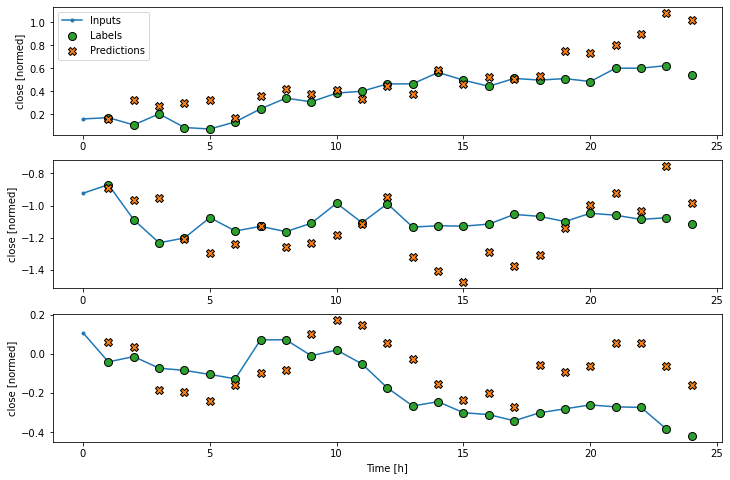

In [39]:
wide_window.plot(linear)


In [40]:
val_performance['Linear']

[0.03673647344112396, 0.15823623538017273]

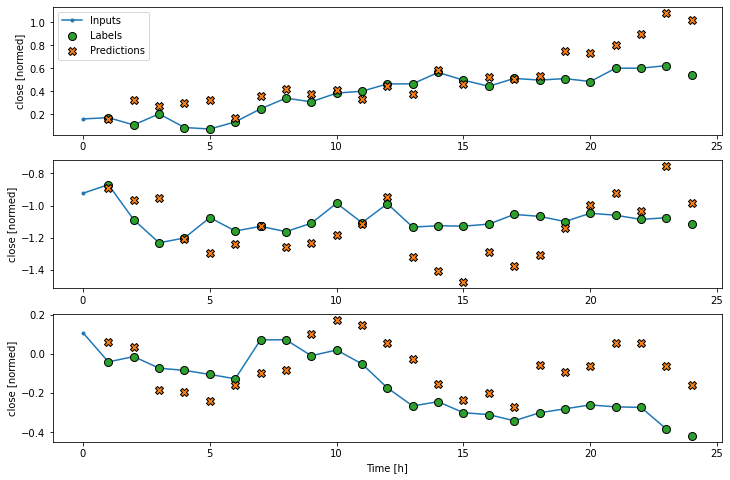

In [41]:
wide_window.plot(linear)

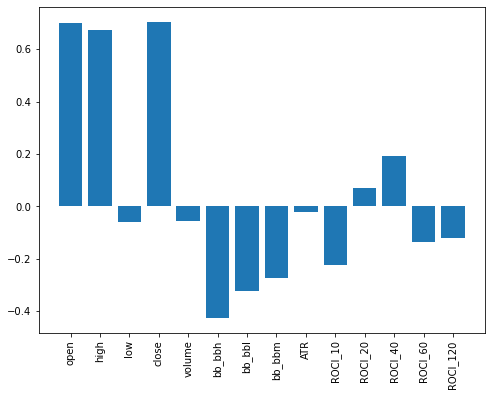

In [42]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


## Dense

In [43]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
45/45 [==============================] - 0s 8ms/step - loss: 0.5766 - mean_absolute_error: 0.4668 - val_loss: 0.0192 - val_mean_absolute_error: 0.1121
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0183 - mean_absolute_error: 0.0997 - val_loss: 0.0135 - val_mean_absolute_error: 0.0951
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0775 - val_loss: 0.0102 - val_mean_absolute_error: 0.0823
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0674 - val_loss: 0.0087 - val_mean_absolute_error: 0.0754
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0076 - val_mean_absolute_error: 0.0701
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0608 - val_loss: 0.0076 - val_mean_absolute_error: 0.0710
Epoch 7/20
13/13 [==========

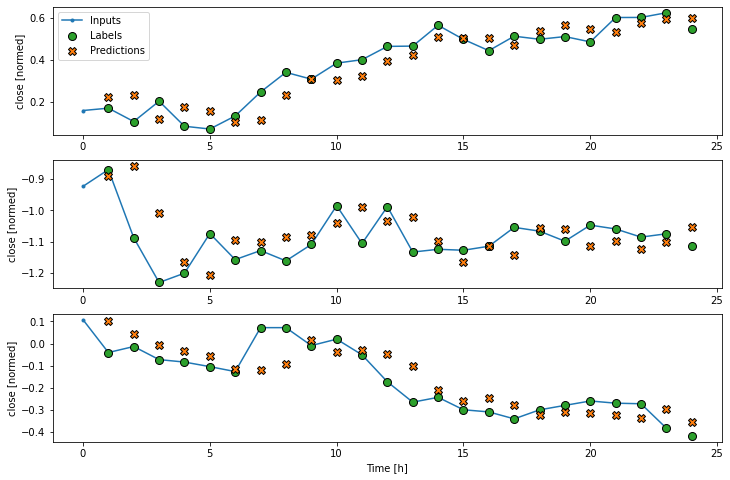

In [44]:
wide_window.plot(dense)

## RNN

In [46]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
#print('Output shape:', lstm_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 24, 14)


In [47]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 14)
Output shape: (32, 1)


In [ ]:
'''
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
'''

In [ ]:
#wide_window.plot(lstm_model)
